# NLP Case

In deze casus bouwen we een model dat in staat is om sentiment in tekst te kunnen herkennen. Het model wordt gebouwd op een dataset van 1,6 miljoen tweets.

Deze modellen kunnen bijvoorbeeld gebruikt worden om te bepalen hoe succesvol een mediacampagne geweest is of om aandelen te verhandelen op basis van hoe positief of negatief een bedrijf in het nieuws komt.


Voor deze case hebben we twee modellen gekozen:
* Een Word2Vec model waarbij eerst woorden omgezet worden in abstracte karakteristieken, vervolgens twee Bidirectional Long Short-Term Memory die zoeken naar de verbanden en daarna een aantal reguliere lagen die deze informatie omzet in een antwoord.
* Exact hetzelfde model als hierboven beschreven, maar dat werkt op basis van letters in plaats van woorden. Deze aanpak werd geïntroduceerd door __[Zhang, Zhao en LeCun](https://papers.nips.cc/paper/5782-character-level-convolutional-networks-for-text-classification.pdf)__ in 2015. Dit soort modellen werken goed wanneer de lengte van de tekst beperkt is.


De structuur van dit notebook is als volgt opgebouwd:
* Data verkenning
* Model suggesties
* Data preprocessing
* Word-based model
* Character-based model

## Data exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
path = "/Users/Laurens-Jan/Desktop/ML/NLP Case/"
file_name = "training.1600000.processed.noemoticon.csv"
file = os.path.join(path, file_name)

In [6]:
column_names = ['Sentiment', 'ID', 'Date', 'Query', 'Username', 'Text']

df = pd.read_csv(file, header=None, names=column_names, encoding = "ISO-8859-1")

In [7]:
df.head()

,Sentiment,ID,Date,Query,Username,Text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [8]:
df.shape

(1600000, 6)

In [10]:
df['Text'].str.len().max()

374

In [12]:
df['Sentiment'].value_counts()/len(df)

4    0.5
0    0.5
Name: Sentiment, dtype: float64

## Algemene Data Pre-processing

Hoewel we meerdere modellen bouwen, kunnen de volgende pre-processing stappen voor beide modellen uitgevoerd worden:
* Data set verkleinen
* Y-waardes omvormen naar 0 en 1, i.p.v. 0 en 4
* De dataset splitten in Train, Cross-Validation (CV) en Test

### Data set verkleinen

De dataset bestaand uit 1.6 miljoen tweets. Voor instructie doeleinden is het niet essentieel om de hele dataset te gebruiken. Door slechts een deel te gebruiken, kunnen we het proces versnellen.

Je boet in op prestatie van het model door dit te doen, maar dat is minder van belang voor deze case. We willen namelijk laten zien hoe de code achter het model functioneert.

We kiezen een arbitraire hoeveelheid van 160.000 tweets.

In [52]:
Text, _, Sentiment, _ = train_test_split(df['Text'], df["Sentiment"], test_size=0.9, random_state=42)

### Y-waardes omvormen

In [53]:
from sklearn.preprocessing import OneHotEncoder

onehotencoder = OneHotEncoder(sparse=False) 
Y = onehotencoder.fit_transform(Sentiment.to_numpy().reshape(-1,1))

### Split dataset in Train, Cross-Validation (CV), and Test

In [54]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(Text, Y, test_size=0.1, random_state=42)
X_cv, X_test, Y_cv, Y_test = train_test_split(X_test, Y_test, test_size=0.5, random_state=42)

In [55]:
print("{} records in train, {} records in cv, {} records in test".format(len(X_train), len(X_cv), len(X_test)))

144000 records in train, 8000 records in cv, 8000 records in test


## Word-based model

### Data Pre-processing

#### Verwijder interpunctie

In [56]:
import string

X_train_wm = X_train.str.translate(str.maketrans('', '', string.punctuation))
X_cv_wm = X_cv.str.translate(str.maketrans('', '', string.punctuation))
X_test_wm = X_test.str.translate(str.maketrans('', '', string.punctuation))

In [57]:
X_train_wm = X_train_wm.astype(str)
X_cv_wm = X_cv_wm.astype(str)
X_test_wm = X_test_wm.astype(str)

#### Tokenize tekst

Creëer een tokenizer, die een dictionary opbouwt van alle mogelijke woorden in de training set gekoppeld aan een numerieke index. Vervolgens zetten we de zinnen om in integers, die corresponderen met de index van het eerder opgestelde woordenboek.

In [58]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

In [59]:
tokenizer_wm = Tokenizer(lower=True, oov_token="<OOV>")
tokenizer_wm.fit_on_texts(X_train_wm)

print("Number of words in Tokenizer: {}".format(len(tokenizer_wm.word_index)))

Number of words in Tokenizer: 145988


In [67]:
sequences_train_wm = tokenizer_wm.texts_to_sequences(X_train_wm)
sequences_cv_wm = tokenizer_wm.texts_to_sequences(X_cv_wm)
sequences_test_wm = tokenizer_wm.texts_to_sequences(X_test_wm)

#### Pad sequences

Gebruik pad_ sequences om alle zinnen dezelfde lengte te geven. Het model is niet in staat om om te gaan met een variabele lengte van vectors en matrices. Het maximum aantal woorden in een zin is 35. Voor nu is dit kort genoeg om de zin niet af te moeten korten.

In [68]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

sequences_train_wm = pad_sequences(sequences_train_wm, padding='post', maxlen=35)
sequences_cv_wm = pad_sequences(sequences_cv_wm, padding='post', maxlen=35)
sequences_test_wm = pad_sequences(sequences_test_wm, padding='post', maxlen=35)

### Model

#### Bouw, Compile and Fit Model

Ons NLP model bestaat uit een Embedding laag,  een LSTM laag en vervolgens wordt de matrix omgevorm tot een vector waarna een aantal normale lagen de verbanden leggen om tot een uitkomst te komen.

In [70]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, LSTM, Bidirectional

In [32]:
def model_architecture(vocab_size, max_length, lstm_dim, dense_dim):
    
    model = Sequential()

    model.add(Embedding(vocab_size, 64, input_length=max_length))
    model.add(Bidirectional(LSTM(lstm_dim, activation='tanh')))
    model.add(Flatten())
    model.add(Dense(dense_dim, activation='relu'))
    model.add(Dense(dense_dim, activation='relu'))
    model.add(Dense(dense_dim, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    
    return model

In [74]:
vocab_size = len(tokenizer_wm.word_index) + 1
max_length = sequences_train_wm.shape[1]
lstm_dim = 64
dense_dim = 128

model_wm = model_architecture(vocab_size, max_length, lstm_dim, dense_dim)

In [75]:
# compile the model
model_wm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
# summarize the model
print(model_wm.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 35, 64)            9343296   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               66048     
_________________________________________________________________
flatten_2 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_10 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_11 (Dense)             (None, 2)                

In [76]:
%%time
history_wm = model_wm.fit(sequences_train_wm, Y_train, validation_data=(sequences_cv_wm, Y_cv), batch_size=64, epochs=5)

Train on 144000 samples, validate on 8000 samples
Epoch 1/5
144000/144000 [==============================] - 333s 2ms/sample - loss: 0.4745 - acc: 0.7724 - val_loss: 0.4307 - val_acc: 0.7964
Epoch 2/5
144000/144000 [==============================] - 319s 2ms/sample - loss: 0.2750 - acc: 0.8875 - val_loss: 0.4907 - val_acc: 0.7826
Epoch 3/5
144000/144000 [==============================] - 325s 2ms/sample - loss: 0.1556 - acc: 0.9387 - val_loss: 0.5979 - val_acc: 0.7739
Epoch 4/5
144000/144000 [==============================] - 339s 2ms/sample - loss: 0.0995 - acc: 0.9613 - val_loss: 0.6877 - val_acc: 0.7600
Epoch 5/5
144000/144000 [==============================] - 359s 2ms/sample - loss: 0.0703 - acc: 0.9725 - val_loss: 0.8484 - val_acc: 0.7569
CPU times: user 1h 4min 11s, sys: 12min 30s, total: 1h 16min 42s
Wall time: 27min 54s


In [38]:
def loss_graph(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='lower left')
    
    plt.show()

In [77]:
def acc_graph(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='lower left')
    
    plt.show()

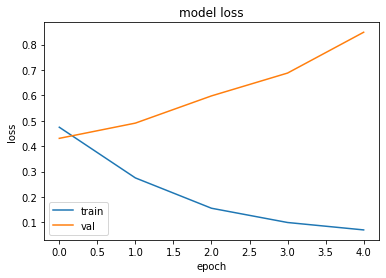

In [78]:
loss_graph(history_wm)

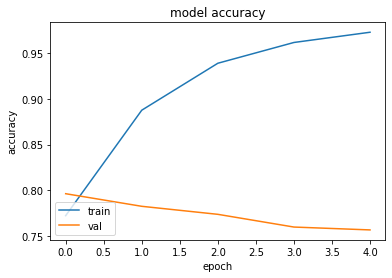

In [79]:
acc_graph(history_wm)

## Character-based model

### Data Pre-Processing

In [80]:
X_train_cm = X_train.astype(str)
X_cv_cm = X_cv.astype(str)
X_test_cm = X_test.astype(str)

#### Tokenize tekst

In [81]:
tokenizer_cm = Tokenizer(lower=True, oov_token="<OOV>", char_level=True)
tokenizer_cm.fit_on_texts(X_train_cm)

print("Number of characters in Tokenizer: {}".format(len(tokenizer_cm.word_index)))

Number of characters in Tokenizer: 151


In [89]:
sequences_train_cm = tokenizer_cm.texts_to_sequences(X_train_cm)
sequences_cv_cm = tokenizer_cm.texts_to_sequences(X_cv_cm)
sequences_test_cm = tokenizer_cm.texts_to_sequences(X_test_cm)

#### Pad sequences

Gebruik pad_sequences om alle zinnen dezelfde lengte te geven. Het model is niet in staat om om te gaan met een variabele lengte van vectors en matrices. Het maximum aantal woorden in een zin is 35. Voor nu is dit kort genoeg om de zin niet af te moeten korten.

In [91]:
from collections import Counter

tweet_lengths = []
for sequence in sequences_train_cm:
    tweet_lengths.append(len(sequence))

seq_len_count_dict = Counter(tweet_lengths)

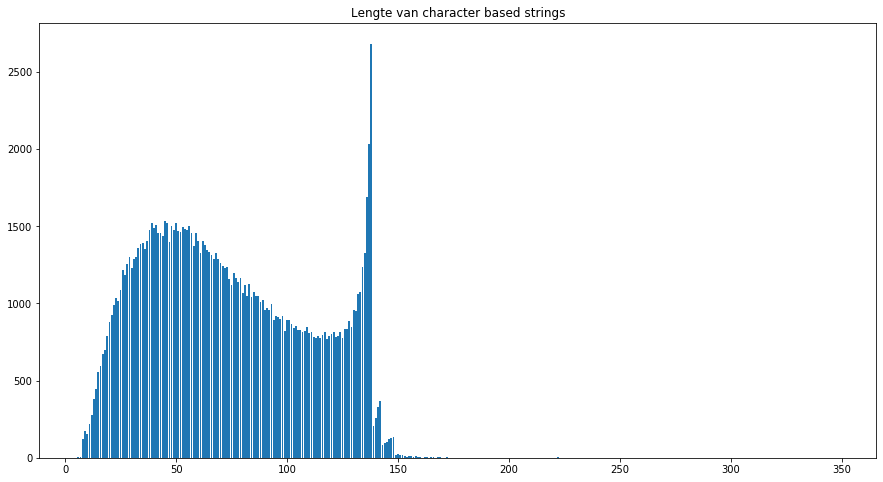

In [92]:
plt.figure(figsize=(15,8))
plt.title("Lengte van character based strings")
plt.bar(list(seq_len_count_dict.keys()), seq_len_count_dict.values())
plt.show()

In [93]:
sequences_train_cm = pad_sequences(sequences_train_cm, padding='post', maxlen=150)
sequences_cv_cm = pad_sequences(sequences_cv_cm, padding='post', maxlen=150)
sequences_test_cm = pad_sequences(sequences_test_cm, padding='post', maxlen=150)

### Model

Het model volgt dezelfde architectuur als het word-based model. Dit doen we om te onderzoeken wat het effect is van de character-based benadering.

Deze aanpak leidt tot fors minder trainbare parameters in de eerste laag, maar doordat de LSTM laag langer memory moet bijhouden kost het character-based model toch meer rekenkracht.

#### Bouw, Compile and Fit Model

In [96]:
vocab_size_cm = len(tokenizer_cm.word_index) + 1
max_length = sequences_train_cm.shape[1]
lstm_dim = 64
dense_dim = 128

model_cm = model_architecture(vocab_size_cm, max_length, lstm_dim, dense_dim)

In [97]:
# compile the model
model_cm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
# summarize the model
print(model_cm.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 150, 64)           9728      
_________________________________________________________________
bidirectional_4 (Bidirection (None, 128)               66048     
_________________________________________________________________
flatten_4 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_17 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_18 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_19 (Dense)             (None, 2)                

In [98]:
%%time
history_cm = model_cm.fit(sequences_train_cm, Y_train, validation_data=(sequences_cv_cm, Y_cv), epochs=5)

Train on 144000 samples, validate on 8000 samples
Epoch 1/5
144000/144000 [==============================] - 711s 5ms/sample - loss: 0.6513 - acc: 0.6184 - val_loss: 0.6285 - val_acc: 0.6614
Epoch 2/5
144000/144000 [==============================] - 608s 4ms/sample - loss: 0.5989 - acc: 0.6796 - val_loss: 0.5614 - val_acc: 0.7082
Epoch 3/5
144000/144000 [==============================] - 605s 4ms/sample - loss: 0.5408 - acc: 0.7292 - val_loss: 0.5247 - val_acc: 0.7360
Epoch 4/5
144000/144000 [==============================] - 612s 4ms/sample - loss: 0.4936 - acc: 0.7606 - val_loss: 0.4783 - val_acc: 0.7659
Epoch 5/5
144000/144000 [==============================] - 615s 4ms/sample - loss: 0.4617 - acc: 0.7820 - val_loss: 0.4613 - val_acc: 0.7822
CPU times: user 2h 23min 46s, sys: 14min 47s, total: 2h 38min 34s
Wall time: 52min 31s


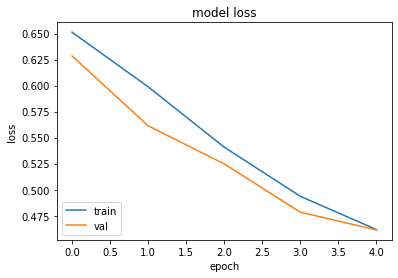

In [99]:
loss_graph(history_cm)

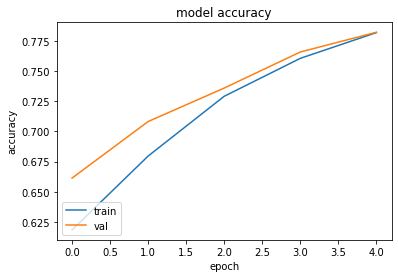

In [100]:
acc_graph(history_cm)